In [1]:
import gymnasium as gym
from bettermdptools.envs.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
import numpy as np
import matplotlib.pyplot as plt
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.decorators import add_to
import seaborn as sns

/opt/anaconda3/envs/ml-hw4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Value Iteration

In [2]:
base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)

V, V_track, V_pi = Planner(blackjack.P).value_iteration(gamma=1.0, n_iters=1000, theta=1e-10)

test_scores = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=V_pi, user_input=False)
print(np.mean(test_scores))

-0.029


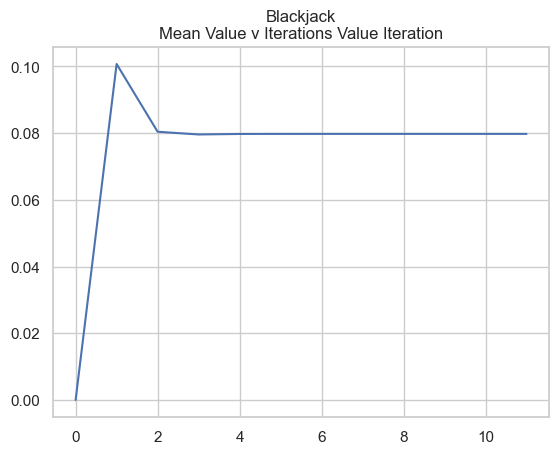

In [3]:
max_value_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "Blackjack\nMean Value v Iterations Value Iteration")

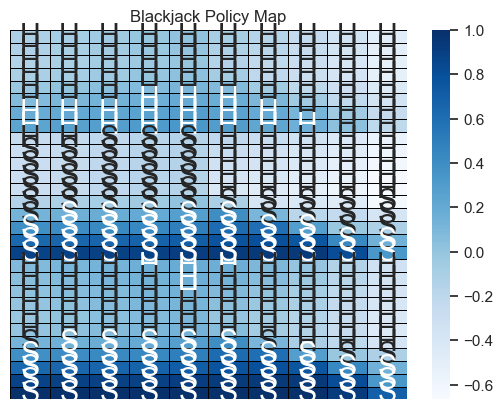

In [5]:

blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

val_max, policy_map = Plots.get_policy_map(V_pi, V, blackjack_actions, blackjack_map_size)

title="Blackjack Policy Map"
Plots.plot_policy(val_max, policy_map, blackjack_map_size, title)

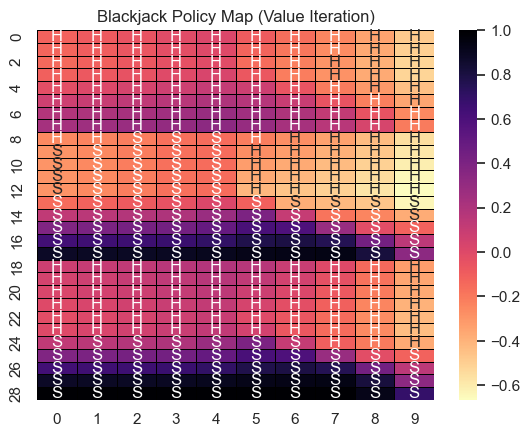

In [13]:
@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("magma_r", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

title = "Blackjack Policy Map (Value Iteration)" 
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

Value Iteration converged at iteration: 11


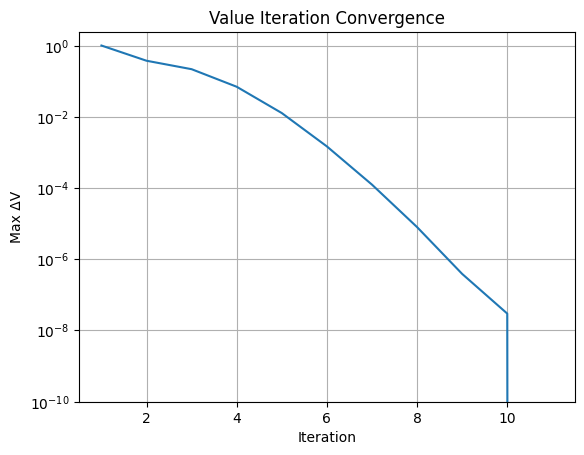

In [28]:
def detect_convergence(V_track, theta=1e-10):
    diffs = np.abs(V_track[1:] - V_track[:-1])
    max_diffs = np.max(diffs, axis=1)
    for i, d in enumerate(max_diffs):
        if d < theta:
            return i + 1
    return len(max_diffs)

converged_iter = detect_convergence(V_track, theta=1e-10)
print(f"Value Iteration converged at iteration: {converged_iter}")


def plot_convergence(V_track, theta=1e-10):
    diffs = np.abs(V_track[1:] - V_track[:-1])
    max_diffs = np.max(diffs, axis=1)

    cutoff = np.argmax(max_diffs < theta) + 1
    max_diffs_trimmed = max_diffs[:cutoff]

    plt.plot(range(1, cutoff + 1), max_diffs_trimmed)
    plt.xlabel("Iteration")
    plt.ylabel("Max ΔV")
    plt.title("Value Iteration Convergence")
    plt.yscale("log")
    plt.ylim(bottom=1e-10)
    plt.grid(True)
    plt.show()

plot_convergence(V_track, theta=1e-10)

# Policy Iteration

In [8]:
base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)

P, P_track, P_pi = Planner(blackjack.P).policy_iteration(gamma=1.0, n_iters=50, theta=1e-10)

test_scores = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=P_pi, user_input=False)
print(np.mean(test_scores))

-0.034


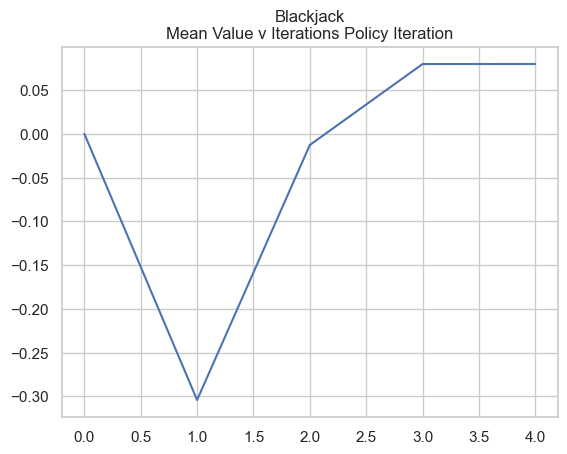

In [10]:
max_value_per_iter = np.trim_zeros(np.mean(P_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "Blackjack\nMean Value v Iterations Policy Iteration")

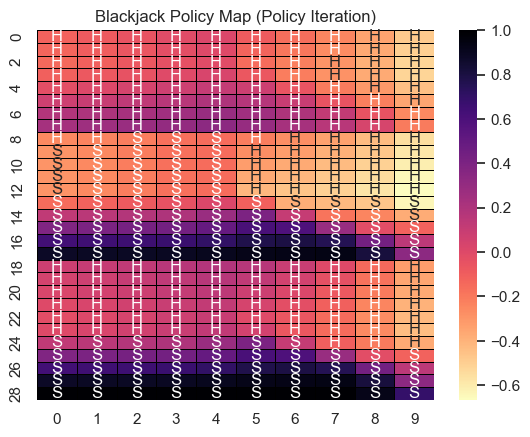

In [12]:
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

val_max, policy_map = Plots.get_policy_map(P_pi, P, blackjack_actions, blackjack_map_size)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("magma_r", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

title = "Blackjack Policy Map (Policy Iteration)"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

Policy Iteration converged at iteration: 6


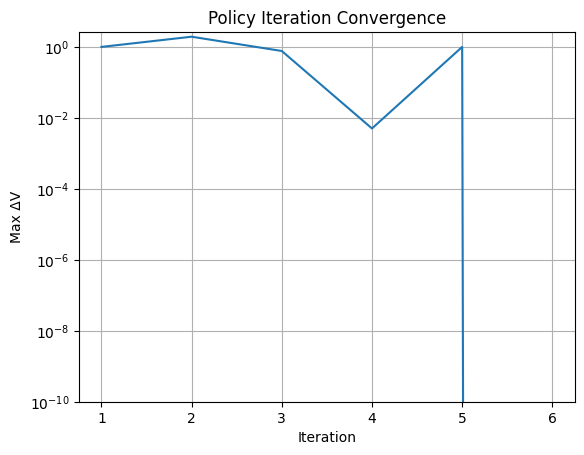

In [ ]:
def detect_convergence(V_track, theta=1e-10):
    diffs = np.abs(V_track[1:] - V_track[:-1])
    max_diffs = np.max(diffs, axis=1)
    for i, d in enumerate(max_diffs):
        if d < theta:
            return i + 1
    return len(max_diffs)

converged_iter = detect_convergence(P_track, theta=1e-10)
print(f"Policy Iteration converged at iteration: {converged_iter}")


def plot_convergence(P_track, theta=1e-10):
    diffs = np.abs(P_track[1:] - P_track[:-1])
    max_diffs = np.max(diffs, axis=1)

    cutoff = np.argmax(max_diffs < theta) + 1
    max_diffs_trimmed = max_diffs[:cutoff]

    plt.plot(range(1, cutoff + 1), max_diffs_trimmed)
    plt.xlabel("Iteration")
    plt.ylabel("Max ΔV")
    plt.title("Policy Iteration Convergence")
    plt.yscale("log")
    plt.ylim(bottom=1e-10)
    plt.grid(True)
    plt.show()

plot_convergence(P_track, theta=1e-10)

In [ ]:
def compare_policies(pi_value, pi_policy):
    all_states = set(pi_value.keys()).union(set(pi_policy.keys()))
    mismatches = []

    for s in all_states:
        a_value = pi_value.get(s)
        a_policy = pi_policy.get(s)
        if a_value != a_policy:
            mismatches.append((s, a_value, a_policy))

    if not mismatches:
        print("✅ Value Iteration and Policy Iteration produce the SAME policy.")
    else:
        print(f"❌ Policies differ at {len(mismatches)} states.")
        print("Examples (state, value_iter_action, policy_iter_action):")
        for m in mismatches[:10]:
            print(m)

compare_policies(P_pi, V_pi)

✅ Value Iteration and Policy Iteration produce the SAME policy.


In [47]:
def decode_state(state_index):
    """
    Converts flat index 0–289 into (player_sum, dealer_card, usable_ace).
    """
    player_index = state_index // 10
    dealer_index = state_index % 10

    # Dealer card 0–9 corresponds to 2–11 (T is 10, A is 11)
    dealer_card = dealer_index + 2

    if player_index <= 17:  # H4–H21 (no usable ace)
        player_sum = player_index + 4
        usable_ace = False
    elif 18 <= player_index <= 27:  # S12–S21 (usable ace)
        player_sum = player_index
        usable_ace = True
    elif player_index == 28:  # Blackjack
        player_sum = 21
        usable_ace = True
    else:
        raise ValueError(f"Invalid player_index: {player_index}")

    return (player_sum, dealer_card, usable_ace)

pi_value_named = {decode_state(s): a for s, a in V_pi.items()}
pi_policy_named = {decode_state(s): a for s, a in P_pi.items()}

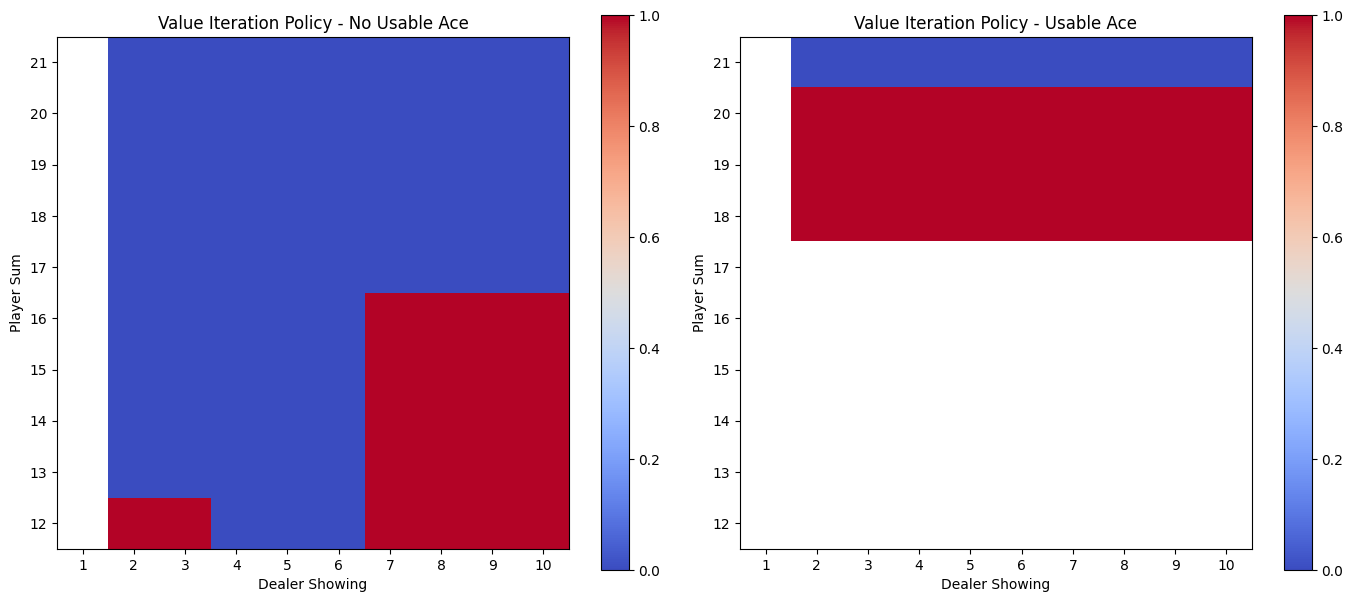

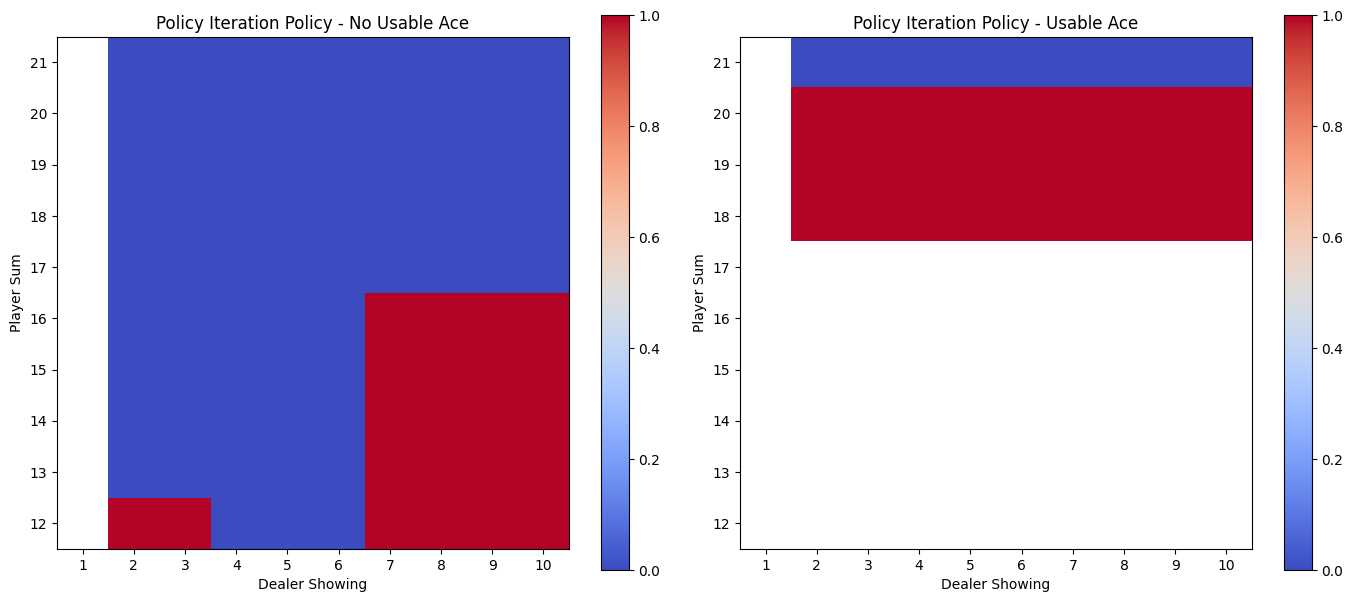

In [48]:
def policy_heatmap(pi, title="Policy Heatmap"):
    usable_ace_grid = np.full((10, 10), np.nan)
    no_usable_ace_grid = np.full((10, 10), np.nan)

    for (player_sum, dealer_card, usable_ace), action in pi.items():
        if 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
            row = player_sum - 12
            col = dealer_card - 1
            if usable_ace:
                usable_ace_grid[row, col] = action
            else:
                no_usable_ace_grid[row, col] = action

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    for ax, grid, title_suffix in zip(
        axs,
        [no_usable_ace_grid, usable_ace_grid],
        ["No Usable Ace", "Usable Ace"]
    ):
        im = ax.imshow(grid, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(10))
        ax.set_yticklabels(range(12, 22))
        ax.set_xlabel("Dealer Showing")
        ax.set_ylabel("Player Sum")
        ax.set_title(f"{title} - {title_suffix}")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

policy_heatmap(pi_value_named, title="Value Iteration Policy")
policy_heatmap(pi_policy_named, title="Policy Iteration Policy")